# 1. Component 1: Topic proposal

## 1.1 Introduction

For my project, I've selected a synthetic dataset known as "Fraudulent E-Commerce Transactions." This dataset was created to simulate typical online shopping transactions, with a specific focus on detecting fraudulent activities. It comprises an extensive set of 1,472,952 transactions and has 16 features that capture a wide range of information relevant to both genuine and fraudulent transactions.

In my analysis, I'm particularly interested in the 'Transaction ID' and 'Customer ID,' which uniquely identify each transaction and customer, respectively. The 'Transaction Amount' and 'Transaction Date' provide financial and temporal details of each purchase. Payment methods include options like credit cards and PayPal, and the 'Product Category' gives insights into what was bought. The 'Quantity' field shows the number of items per transaction.

Customer demographics are captured in fields like 'Customer Age' and 'Customer Location,' which help in profiling typical purchasing patterns. The type of device used, along with the IP address from which the transaction was created, offers additional layers of data for analysing access patterns and potential security breaches. Shipping and billing addresses might highlight discrepancies used to flag frauds.

Moreover, the dataset includes an 'Is Fraudulent' label, marking each transaction as fraudulent or legitimate, which is crucial for my goal of training machine learning models to detect fraud. The 'Account Age Days' and 'Transaction Hour' provide further context, revealing how newly created accounts might behave and at what times transactions occur, which can be indicative of fraud.

This dataset is entirely synthetic, generated through Python's Faker library and tailored algorithms to reflect realistic transaction patterns, including fraudulent scenarios. It's intended solely for educational and research purposes, providing a safe and ethical way to study fraud detection without compromising real personal data.

As I dive into this dataset, my objective is to use some of these detailed features to build robust models that can not only detect fraudulent transactions with high accuracy but also offer insights into the dynamics of e-commerce fraud. This work could then be used as a benchmark for developing and testing future fraud detection systems in a controlled, scalable manner.

I will aim to answer:

Can we identify characteristics of customers who are more likely to be involved in fraudulent transactions?

What are the key features that contribute to the likelihood of a transaction being fraudulent?

Can we build an accurate machine learning model to predict whether a transaction is fraudulent or not?

## 1.2 Dataset

I found my data in Kaggle: https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions

Note: The notebook submitted is already run as it is time-consuming to run again.

The choice of a 393 MB dataset was strategic and aimed at demonstrating the methodology's effectiveness before scaling up. I tried previous larger datasets for fraud; however, it seemed to be very time-consuming with it taking typically 6 to 8 hours to run. Even though it still took a couple of hours to run, this size proved sufficient to validate the functionality of data processing pipelines while being manageable within the computational resources available.

For my analysis, I will use Apache Spark and its MLlib library, both of which are staples in the industry for handling large datasets in a distributed computing environment. Spark can scale horizontally, allowing for the same analytical processes to be applied to larger datasets without significant alterations to the code.  Moreover, MLlib provides robust machine-learning algorithms that can be tuned and optimised for a variety of tasks, including binary classification.

In practice, the predictive model developed in this coursework could be useful in an e-commerce platform's fraud detection system. By predicting fraudulent transactions accurately, this model can help in flagging and handling suspicious activities. This will help mitigate any potential losses. Additionally, the insights gained from the model’s predictions could inform strategic decisions regarding resource allocation, customer service, and security measures. 
For my project proposal, I will start with data pre-processing to ensure that the data is ready for effective EDA and modelling. Following this, I will apply various machine learning models, including Random Forest, Logistic Regression, and Gradient Boosted Trees, to train and evaluate. The best model will then be tuned using techniques such as random search to optimise their performance. It is important to consider that in a real-world scenario, the patterns of fraudulent transactions may evolve as the e-commerce environment is always changing. Therefore, these models need to be regularly updated with the new data to remain accurate and relevant. Spark allows for real-time fraud detection as the developed model can be saved and distributed across the e-commerce platform.

# 2. Component 2: Implementation of the proposed project

In [ ]:
# Copy the data from local disk to the cluster

#scp /Users/jerid/Downloads/archive/"Fraudulent_E-Commerce_Transaction_Data.csv" xxx@dsm1.doc.gold.ac.uk:~

#create the frauddata directory in HDFS

#hadoop fs -mkdir -p /user/xxx/frauddata

# Copy directory onto HDFS

#hdfs dfs -put ~/Fraudulent_E-Commerce_Transaction_Data.csv /user/xxx/frauddata/

In [1]:
import pyspark
from pyspark import SparkContext, SparkConf 
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
import pandas as pd
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import mean, stddev, min, max, count
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, lower, regexp_replace, trim
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean, stddev, min, max, count
from pyspark.sql.functions import when
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Initialize Spark Context
conf = SparkConf().setAppName("fraud_analysis").set("spark.driver.maxResultSize", "0")
sc = SparkContext(conf=conf)
sq = SQLContext(sc)

In [3]:
# Define the paths to the CSV files in HDFS
datapath = "hdfs:///user/xxx/frauddata/Fraudulent_E-Commerce_Transaction_Data.csv"

In [ ]:
# Import data as DataFrames
#fraud_df = sq.read.csv(datapath, header=True, inferSchema=True)

In [ ]:
# Verify the type
#print(type(fraud_df))

# Show the first few rows
#fraud_df.show()

In [ ]:
# Count missing values per column
#for column in fraud_df.columns:
    #missing_count = fraud_df.filter((col(column) == "") | col(column).isNull() | (col(column) == "null")).count()
    #if missing_count > 0:
        #print(f"Column {column} has {missing_count} missing values")

The data looked like it was not read correctly as there were many null values. I then double checked the null values to see if it was correct. However, I could still see that the file was not being read properly, suggesting that Spark was unable to correctly parse the CSV file. I have commented this out for easy reading but chose to keep it in as an example for troubleshooting challenges. 

I am now going to check the multiline option by checking that it is set to True to handle entries across multiple lines properly. 

In [4]:
# Read the CSV file
fraud_df = sq.read.csv(
    datapath,
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)
fraud_df.show(5)
fraud_df.printSchema()

+--------------------+--------------------+------------------+-------------------+--------------+----------------+--------+------------+-----------------+-----------+---------------+--------------------+--------------------+-------------+----------------+-----------------+
|
+--------------------+--------------------+------------------+-------------------+--------------+----------------+--------+------------+-----------------+-----------+---------------+--------------------+--------------------+-------------+----------------+-----------------+
|15d2e414-8735-46f...|d1b87f62-51b2-493...|             58.09|2024-02-20 05:58:41| bank transfer|     electronics|       1|          17|    Amandaborough|     tablet| 212.195.49.198|Unit 8934 Box 005...|Unit 8934 Box 005...|            0|              30|              5.0|
|0bfee1a0-6d5e-40d...|37de64d5-e901-4a5...|            389.96|2024-02-25 08:09:45|    debit card|     electronics|       2|          40|     East Timothy|    desktop|208.106.24

The multiline has properly handled the multi-line address field and showing no non-null values in the output. Now that the data has loaded been successfully I will briefly check the data with the describe function and then move on to the data cleaning. 

In [5]:
fraud_df.describe().show()

+-------+--------------------+--------------------+------------------+--------------+----------------+-----------------+------------------+-----------------+-----------+-----------+--------------------+--------------------+-------------------+------------------+-----------------+
|
+-------+--------------------+--------------------+------------------+--------------+----------------+-----------------+------------------+-----------------+-----------+-----------+--------------------+--------------------+-------------------+------------------+-----------------+
|  count|             1472952|             1472952|           1472952|       1472952|         1472952|          1472952|           1472952|          1472952|    1472952|    1472952|             1472952|             1472952|            1472952|           1472952|          1472952|
|   mean|                null|                null| 226.7683092388607|          null|            null| 3.00023015006599|  34.5120811811926|             nul

### 2.1 Data Cleaning

#### Checking duplicates

In [6]:
#I will check for duplicates in transaction id column
duplicate_transaction_ids = fraud_df.groupBy("Transaction ID")\
                                    .count()\
                                    .filter(col("count") > 1)

# Now I will display duplicate Transaction IDs and their counts
duplicate_transaction_ids.show()

+--------------+-----+
|Transaction ID|count|
+--------------+-----+
+--------------+-----+



There are no duplicates. 

#### Checking for missing values

In [7]:
# Count missing values per column
for column in fraud_df.columns:
    missing_count = fraud_df.filter((col(column) == "") | col(column).isNull() | (col(column) == "null")).count()
    # Print missing values count for every column
    print(f"Column {column} has {missing_count} missing values")

Column Transaction ID has 0 missing values
Column Customer ID has 0 missing values
Column Transaction Amount has 0 missing values
Column Transaction Date has 0 missing values
Column Payment Method has 0 missing values
Column Product Category has 0 missing values
Column Quantity has 0 missing values
Column Customer Age has 0 missing values
Column Customer Location has 0 missing values
Column Device Used has 0 missing values
Column IP Address has 0 missing values
Column Shipping Address has 0 missing values
Column Billing Address has 0 missing values
Column Is Fraudulent has 0 missing values
Column Account Age Days has 0 missing values
 has 0 missing valuesur


In my analysis, I took a systematic approach to examine the presence of missing values across all columns in the dataset. Using a simple yet effective Spark SQL function, I iterated through each column to count and print the number of missing entries. There were no missing values. If there were missing values, where missing data may not compromise the transaction's validity, I may have chosen to impute missing values using statistical methods (median for numerical data and mode for categorical data).

#### Converting Data Types

Ensuring that each feature in the dataset is the correct data type is another vital step in my preprocessing efforts. I will convert key numerical fields that were initially read as strings into more appropriate data types, enabling accurate numerical operations and analysis:

In [10]:
# Converting the string to double for Transaction Amount
fraud_df = fraud_df.withColumn("Transaction Amount", col("Transaction Amount").cast(DoubleType()))

# Converting string to integer for Account Age Days and Transaction Hour
fraud_df = fraud_df.withColumn("Account Age Days", col("Account Age Days").cast(IntegerType()))

fraud_df = fraud_df.withColumnRenamed("Transaction Hour\r", "Transaction Hour")
fraud_df = fraud_df.withColumn("Transaction Hour", col("Transaction Hour").cast(IntegerType()))

# Printing the updated schema to confirm the changes
fraud_df.printSchema()

# I will now show some data to verify the casts were successful
fraud_df.show(5)

root
 |-- Transaction ID: string (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Transaction Amount: double (nullable = true)
 |-- Transaction Date: timestamp (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Customer Age: integer (nullable = true)
 |-- Customer Location: string (nullable = true)
 |-- Device Used: string (nullable = true)
 |-- IP Address: string (nullable = true)
 |-- Shipping Address: string (nullable = true)
 |-- Billing Address: string (nullable = true)
 |-- Is Fraudulent: integer (nullable = true)
 |-- Account Age Days: integer (nullable = true)
 |-- Transaction Hour: integer (nullable = true)

+--------------------+--------------------+------------------+-------------------+--------------+----------------+--------+------------+-----------------+-----------+---------------+--------------------+--------------------+-------------+-------------

#### Gaining Insights through Statistics

In [11]:
# Select numerical columns for summary statistics
numerical_columns = ["Transaction Amount", "Customer Age", "Account Age Days", "Transaction Hour", "Quantity"]

# Compute basic statistics
stats = fraud_df.select(numerical_columns).describe().show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|Transaction Amount|      Customer Age|  Account Age Days| Transaction Hour|         Quantity|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|           1472952|           1472952|           1472952|          1472952|          1472952|
|   mean| 226.7683092388607|  34.5120811811926|179.64639784595832|11.28696386576073| 3.00023015006599|
| stddev|270.39509886795645|10.003134338650726| 106.8642230429199|6.975995283914701|1.414736473764559|
|    min|              10.0|               -16|                 1|                0|                1|
|    max|          12701.75|                86|               365|               23|                5|
+-------+------------------+------------------+------------------+-----------------+-----------------+



Generally, the variables look okay. Given the range from 1 to 365, the data shows how "old" most accounts are, which helps in identifying any patterns related to the account age and fraudulent activities. Furthermore, the Transaction Hour reveals patterns about when transactions typically occur, e.g.,a high number of transactions occurring at unusual hours. However, there seems to be an anomaly of a negative age with a minimum of -16. Also, the transaction amount seems to have a high standard deviation. Therefore, visualising this later in the EDA will be helpful to understand the skewness or presence of outliers in transaction values. Visualising the rest of the variables will also be helpful to better understand the data. Since age cannot be negative I will handle this first.

#### Correcting the Age by replacing them with the average age of non-negative values

In [14]:
# Calculate the median of ages greater than zero
median_age = fraud_df.filter(col("Customer Age") > 0).approxQuantile("Customer Age", [0.5], 0)[0]

# Replace ages of zero or negative with the median age
fraud_df = fraud_df.withColumn("Customer Age", 
                               when((col("Customer Age") <= 0), median_age)
                               .otherwise(col("Customer Age")))

fraud_df.describe("Customer Age").show()

+-------+-----------------+
|summary|     Customer Age|
+-------+-----------------+
|  count|          1472952|
|   mean|34.52500964050424|
| stddev|9.980012786154026|
|    min|              1.0|
|    max|             86.0|
+-------+-----------------+



#### Checking and Filtering Out Incorrect Entries

In [15]:
# The 'Transaction Amount' should logically be greater than zero
fraud_df = fraud_df.filter(col("Transaction Amount") > 0)
fraud_df.describe("Transaction Amount").show()

+-------+------------------+
|summary|Transaction Amount|
+-------+------------------+
|  count|           1472952|
|   mean| 226.7683092388607|
| stddev|270.39509886795645|
|    min|              10.0|
|    max|          12701.75|
+-------+------------------+



#### Checking unique values for each variable

In [16]:
# I will create a dictionary with column names as keys and the count of distinct values as values
unique_counts = {c: fraud_df.select(c).distinct().count() for c in fraud_df.columns}

# I will now look at the dictionary of unique counts
print(unique_counts)

{'Transaction ID': 1472952, 'Customer ID': 1472952, 'Transaction Amount': 110385, 'Transaction Date': 1346595, 'Payment Method': 4, 'Product Category': 5, 'Quantity': 5, 'Customer Age': 82, 'Customer Location': 99135, 'Device Used': 3, 'IP Address': 1472651, 'Shipping Address': 1472948, 'Billing Address': 1472949, 'Is Fraudulent': 2, 'Account Age Days': 365, 'Transaction Hour': 24}


The transaction ID is 1,472,952. This suggests that there are 1,472,952 unique transaction IDs, indicating unique transactions. This is correct as it matches the amount in the dataset description. The customer ID also matches this, which suggests that each transaction is linked to a unique customer. We can see several other records that are numerical and categorical. We can also see that there are only 2 categories for the target class 'Is Fraudelent', indicating a binary classification of transactions as fraudulent or not.  

#### Drop unnecessary columns like 'Transaction ID' and 'Customer ID' 

In this project we will drop  columns like Transaction ID, Customer ID, Transaction Date,Customer Location and the IP Address so that we can focus on our objectives of identifying the characteristics of customers who are most likely to be involved in fraudaulent transactions. 

In [18]:
fraud_df = fraud_df.drop("Transaction ID", "Customer ID","Transaction Date","Customer Location","IP Address")

print(fraud_df.columns)

['Transaction Amount', 'Payment Method', 'Product Category', 'Quantity', 'Customer Age', 'Device Used', 'Shipping Address', 'Billing Address', 'Is Fraudulent', 'Account Age Days', 'Transaction Hour']


The steps taken in the data cleaning phase were designed to ensure the high quality and reliability of the data feeding into my fraud detection models. By addressing missing values and data type inaccuracies, I aimed to lay a robust foundation for further data analysis and predictive modeling, which leads to more reliable and effective fraud detection capabilities.

### 2.2 EDA

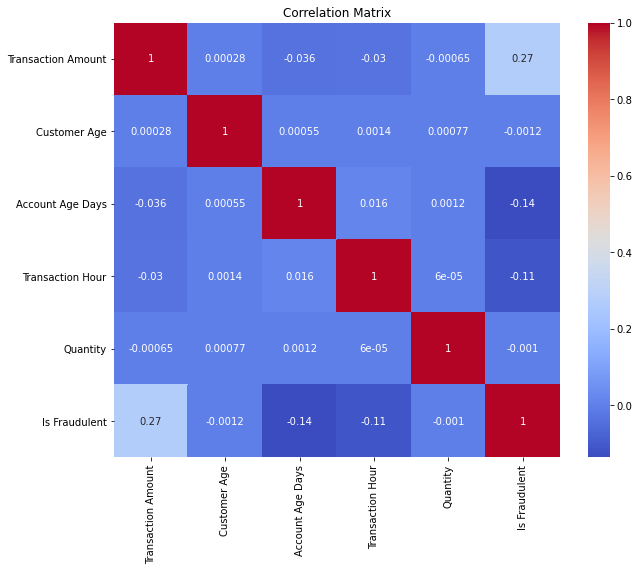

In [26]:
# Select a subset of numerical columns for correlation analysis
numerical_columns = ['Transaction Amount', 'Customer Age', 'Account Age Days', 'Transaction Hour', 'Quantity', 'Is Fraudulent']

# Compute correlation matrix
correlation_data = Statistics.corr(fraud_df.select(numerical_columns).rdd.map(lambda v: Vectors.dense(v)), method="pearson")

# Convert to Pandas DataFrame for plotting
correlation_df = pd.DataFrame(correlation_data, columns=numerical_columns, index=numerical_columns)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

I would like to do a number-by-number analysis and have a text based record of this:

In [27]:
# Correlation matrix of numerical variables
for col1 in numerical_columns:
    for col2 in numerical_columns:
        if col1 != col2:
            corr = fraud_df.stat.corr(col1, col2)
            print(f"Correlation between {col1} and {col2}: {corr}")

Correlation between Transaction Amount and Customer Age: 0.000281285549514959
Correlation between Transaction Amount and Account Age Days: -0.03573307121531578
Correlation between Transaction Amount and Transaction Hour: -0.029909177232542862
Correlation between Transaction Amount and Quantity: -0.0006516208189054034
Correlation between Transaction Amount and Is Fraudulent: 0.27276583085786876
Correlation between Customer Age and Transaction Amount: 0.0002812855495149618
Correlation between Customer Age and Account Age Days: 0.0005451818735390883
Correlation between Customer Age and Transaction Hour: 0.0013585476508331629
Correlation between Customer Age and Quantity: 0.0007690644456886625
Correlation between Customer Age and Is Fraudulent: -0.0011564766228441099
Correlation between Account Age Days and Transaction Amount: -0.03573307121531579
Correlation between Account Age Days and Customer Age: 0.0005451818735390913
Correlation between Account Age Days and Transaction Hour: 0.016409

I made a heatmap to see how different things like the amount spent and customer age are linked. The heatmap used colors to show blue for less connection and red for more. To my surprise, most of the factors I considered weren't strongly linked to each other. The figures, which indicate the strength of a link, were really close to zero for the majority. However, I noticed an interesting pattern where 'Is Fraudulent' and 'Transaction Amount' had a correlation of about 0.27, suggesting that the transaction amount could potentially be a flag for fraud. Even more, 'Account Age Days' and 'Transaction Hour' showed negative correlations with fraud, with 'Account Age Days' presenting a notably stronger negative link. This could imply that newer accounts or transactions during certain hours may be more susceptible to fraudulent activities. These few, yet significant, hints amongst the other weaker correlations tell me that customer behavior is complex and can't be guessed just by looking at simple links between things like age and how much they spend. So now, instead of expecting clear patterns, I will try out some more complex analysis methods to really understand what's going on in the data. 

#### Distribution of numerical columns

In [22]:
def get_histogram_data(column_name, bins):
    return fraud_df.select(column_name).rdd.flatMap(lambda x: x).histogram(bins)

# Creating columns and their respective bins for the histograms
columns_bins = {
    "Transaction Amount": 10,
    "Customer Age": 10,
    "Account Age Days": 12,  # 12 bins for 12 months
    "Transaction Hour": 24,  # 24 bins for 24 hours
    "Quantity": 5
}

# I will create histograms for each column
histograms = {col: get_histogram_data(col, bins) for col, bins in columns_bins.items()}

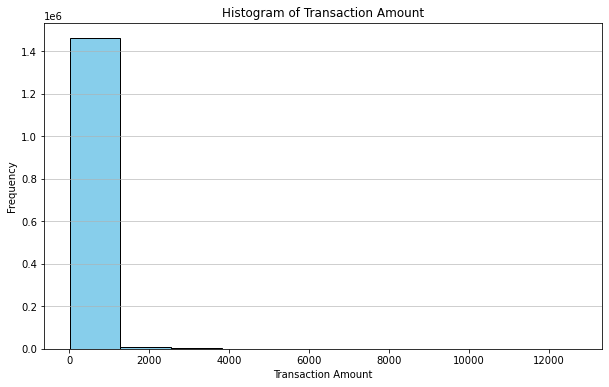

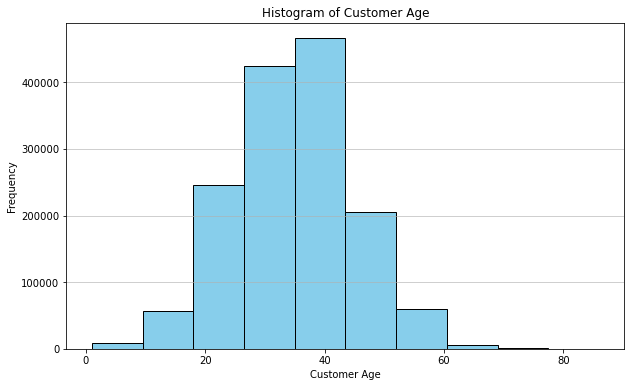

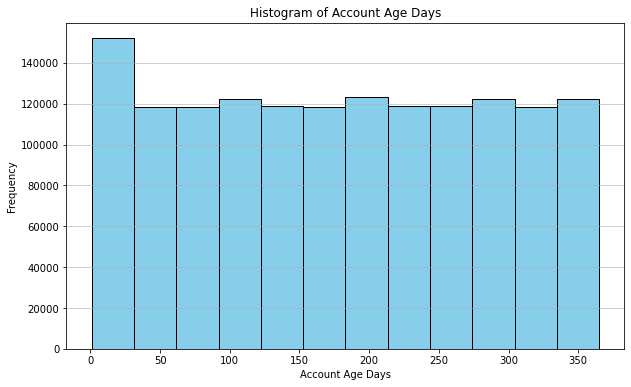

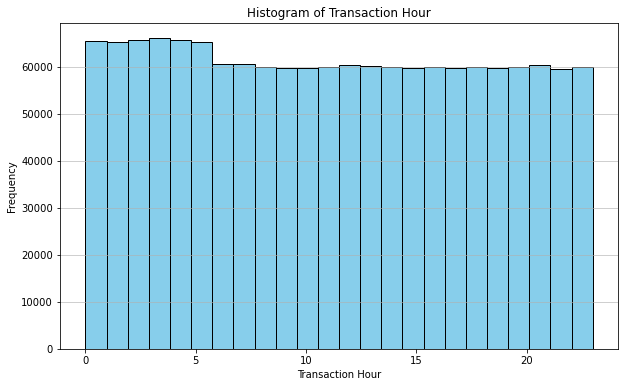

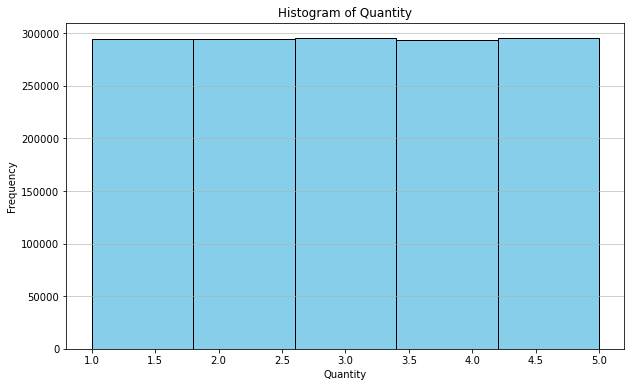

In [23]:
# I will create a function to plot the histograms
def plot_histogram(bins, counts, title, xlabel):
    plt.figure(figsize=(10, 6))
    plt.hist(bins[:-1], bins=bins, weights=counts, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot each histogram
for col, (bins, counts) in histograms.items():
    plot_histogram(bins, counts, f'Histogram of {col}', col)

Histogram of Transaction Amount shows a highly right-skewed distribution, meaning most of the transaction amounts are clustered around the lower end of the scale with some very high transactions creating a long tail to the right. This is typical for transaction data as most purchases tend to be for smaller amounts.

The distribution of customer age appears to be normally distributed, with a peak somewhere in between the mid-30s and early 40s. This suggests that the majority of the customers are in this age range. 

The account age days are generally evenly spread out in terms of their ages. It is uniformly distributed. This could imply a steady acquisition of customers over time or reflect a specific period of data collection.

The quantity of products per transaction ranges from 1 to 5. It shows a very even distribution across the different quantity values which indicates that customers are equally likely to purchase at any given quantity.

The "Transaction Hour" histogram shows a similar frequency for each hour, with slight fluctuations. This suggests that transactions happen with similar frequencies throughout the day, which might indicate that there is no particular time-based patterns for fraudulent activity.

#### Frequencies of Categorical Variables

In [25]:
# I will now create the frequency of Payment Methods
fraud_df.groupBy("Payment Method").count().show()

# Creating the frequency of Product Categories
fraud_df.groupBy("Product Category").count().show()

# Creaating the frequency of Product Categories
fraud_df.groupBy("Device Used").count().show()

+--------------+------+
|Payment Method| count|
+--------------+------+
|    debit card|368277|
| bank transfer|368278|
|        PayPal|367968|
|   credit card|368429|
+--------------+------+

+----------------+------+
|Product Category| count|
+----------------+------+
| health & beauty|295367|
|    toys & games|294266|
|     electronics|295294|
|        clothing|294319|
|   home & garden|293706|
+----------------+------+

+-----------+------+
|Device Used| count|
+-----------+------+
|    desktop|490271|
|     mobile|491743|
|     tablet|490938|
+-----------+------+



The distribution of payment methods is quite balanced with debit cards, bank transfers, PayPal, and credit cards all being used with similar amount of transactions. Product categories are also well represented with health & beauty; toys & games; electronics; clothing; and home & garden categories having a comparable number of transactions. The use of different devices is balanced as well similar number of transactions. 

#### Checking the distribution of how many samples fall into each class

In [28]:
class_distribution = fraud_df.groupBy('Is Fraudulent').count()
class_distribution.show()

+-------------+-------+
|Is Fraudulent|  count|
+-------------+-------+
|            1|  73838|
|            0|1399114|
+-------------+-------+



In [29]:
# I want to now get the total number of rows to see the proportion of each class
total_rows = fraud_df.count()
print(f"Total number of rows in fraud_df: {total_rows}")

Total number of rows in fraud_df: 1472952


There are 73,838 fraudulent transactions, which represent approximately 5.01% of the total transactions. This indicates a relatively small proportion of fraudulent activities within the dataset. There are 1,399,114 non-fraudulent transactions, making up about 94.99% of the dataset. This shows that the majority of transactions are legitimate.

The data is highly imbalanced with a significant skew towards non-fraudulent transactions. This class imbalance is common in fraud detection scenarios because fraudulent activities are generally rare compared to legitimate transactions. Therefore,when training the machine learning model on this data, it's crucial for me to handle this imbalance appropriately to ensure the model doesn't become biased towards predicting non-fraudulent transactions. 


Technqiues, such as oversampling the minority class and undersampling the majority class is necessary.
Evaluation Metrics: Given the imbalance, accuracy might not be a reliable metric alone for evaluating the model performance. Metrics like Precision, Recall, F1-Score, or the Area Under the ROC Curve (AUC-ROC) are more indicative of how well the model is performing, especially in detecting the minority class (fraudulent transactions).

# 3. Planned implementation

## 3.1 Transforming Features/ Feature Engineering

#### Creating Address Match

First I will normalise the addresses to standarsise it before any comparison. This reduces any errors for my machine learning and improves the accuracy of my feature 'Address Match'. 

In [68]:
def normalise_address(address_column):
    try:
        address_column = lower(address_column)  # This converts to lower case to standardise it
        address_column = trim(address_column)  # I will also trim any whitespace

        # I will also generate a typical list of abbreviations in addresses to expand
        abbreviations = {
            "st\\b": "street", "rd\\b": "road", "ave\\b": "avenue", "blvd\\b": "boulevard",
            "dr\\b": "drive", "ctr\\b": "center", "ct\\b": "court", "ln\\b": "lane",
            "pl\\b": "place", "ter\\b": "terrace", "ste\\b": "suite", "apt\\b": "apartment",
            "dept\\b": "department", "fl\\b": "floor", "mt\\b": "mount", "fwy\\b": "freeway",
            "hwy\\b": "highway", "pkwy\\b": "parkway", "sq\\b": "square", "cir\\b": "circle"
        }

        for abbr, full in abbreviations.items():
            address_column = regexp_replace(address_column, abbr, full)
        
        address_column = regexp_replace(address_column, "[^a-z0-9 ]", "")
        return address_column
    except Exception as e:
        print(f"Error normalising address: {e}")
        return None

Now I will apply the normalisation function and check the consistency:

In [69]:
fraud_df = fraud_df.withColumn("Shipping Address", normalise_address(col("Shipping Address")))
fraud_df = fraud_df.withColumn("Billing Address", normalise_address(col("Billing Address")))

# I would like to briefly check a sample of addresses to manually inspect for consistency
fraud_df.select("Shipping Address", "Billing Address").distinct().show(100, truncate=False)

+----------------------------------------------------------------+----------------------------------------------------------------+
|Shipping Address                                                |Billing Address                                                 |
+----------------------------------------------------------------+----------------------------------------------------------------+
|828 strong loaf apartment 646new joshua ut 84798                |828 strong loaf apartment 646new joshua ut 84798                |
|45344 mary hollowsouth ronaldstad court 86106                   |45344 mary hollowsouth ronaldstad court 86106                   |
|95388 robert rue apartment 240millerton ms 22399                |95388 robert rue apartment 240millerton ms 22399                |
|917 petersen roads apartment 764new tara ks 13008               |917 petersen roads apartment 764new tara ks 13008               |
|47486 bradley village apartment 527new annachesterrace tn 57819 |47486 brad

In [65]:
# I will create a new column 'Address Match' to check if the Shipping Address matches the Billing Address
fraud_df = fraud_df.withColumn("Address Match", when(col("Shipping Address") == col("Billing Address"), "Match").otherwise("No Match"))

# I will now check the DataFrame
fraud_df.select("Shipping Address", "Billing Address", "Address Match").show(truncate=False)


+----------------------------------------------------+----------------------------------------------------+-------------+
|Shipping Address                                    |Billing Address                                     |Address Match|
+----------------------------------------------------+----------------------------------------------------+-------------+
|unit 8934 box 0058
dpo aa 05437                     |unit 8934 box 0058
dpo aa 05437                     |Match        |
|634 may keys
port cherylview nv 75063               |634 may keys
port cherylview nv 75063               |Match        |
|16282 dana falls suite 790
rothhaven il 15564       |16282 dana falls suite 790
rothhaven il 15564       |Match        |
|828 strong loaf apt 646
new joshua ut 84798         |828 strong loaf apt 646
new joshua ut 84798         |Match        |
|29799 jason hills apt 439
west richardtown oh 36093 |29799 jason hills apt 439
west richardtown oh 36093 |Match        |
|5699 brittany villages 

This column indicates whether the shipping address matches the billing address for each transaction, which can be a useful feature in detecting potential fraud. Transactions with mismatched addresses could be an indication of fraudulent activity.

Most transactions seem to have matching addresses, with a few exceptions. Where "Address Match" is "No Match" is particularly interesting for fraud detection purposes. This is a common indicator of fraud analysis to look for discrepancies between billing and shipping information, as it can sometimes suggest that the purchase is not legitimate. According to the research [1], fraudsters may use different addresses to avoid raising suspicion and businesses can reduce this risk by flagging discrepancies between billing and shipping addresses through using address verification systems 

This "Address Match" feature I created along with other engineered features will be helpful in training my machine learning models. 

#### Creating an interaction feature between 'Transaction Amount' and 'Customer Age'

The 'Amount_Age_Interaction' feature investigates if purchasing behavior varies by age, potentially flagging fraud. For younger customers', large transactions may signal fraud, as they typically spend much less. Similarly, unusually large purchases by older customers could indicate exploitation. This feature will help my models detect any anomalies against age based spending trends. It allows for customer segmentation for identifying demographic-specific patterns of fraud.

In [35]:
# Creating an interaction feature between 'Transaction Amount' and 'Customer Age'
fraud_df = fraud_df.withColumn('Amount_Age_Interaction', col('Transaction Amount') * col('Customer Age'))

# Viewing the newly created feature
fraud_df.select('Amount_Age_Interaction').summary().show()

+-------+----------------------+
|summary|Amount_Age_Interaction|
+-------+----------------------+
|  count|               1472952|
|   mean|     7829.937124265001|
| stddev|     9985.983134476417|
|    min|                 10.42|
|    25%|    2180.2000000000003|
|    50%|     4958.429999999999|
|    75%|              10050.33|
|    max|              539508.6|
+-------+----------------------+



The summary statistics suggest that there's a broad range of values in this interaction feature, with the maximum being significantly higher than the mean, which is indicative of a right-skewed distribution. Therefore, the transactional data suggests that younger customers may tend to make smaller transactions and older customers may make larger ones.

#### Creating an interaction feature between 'Transaction Hour' and 'Quantity'

I would like to test my hypothesis. I may expect larger quantities to be ordered during business hours rather than in the middle of the night.

Therefore, I will also create a feature that flags these unusual combinations. 

In [38]:
# I will calculate and display the statistics
median = fraud_df.stat.approxQuantile("Quantity", [0.5], 0.01)
percentile_75 = fraud_df.stat.approxQuantile("Quantity", [0.75], 0.01)
percentile_90 = fraud_df.stat.approxQuantile("Quantity", [0.90], 0.01)

print(f"Median (50th percentile) of Quantity: {median[0]}")
print(f"75th percentile of Quantity: {percentile_75[0]}")
print(f"90th percentile of Quantity: {percentile_90[0]}")


Median (50th percentile) of Quantity: 3.0
75th percentile of Quantity: 4.0
90th percentile of Quantity: 5.0


In [41]:
# User Defined Function (UDF) for checking unusual combinations
def check_unusual_combination(hour, quantity):
    if (hour < 6 or hour >= 20) and quantity > threshold_quantity:
        return 'Unusual'
    else:
        return 'Normal'

# Registering the UDF
check_unusual_combination_udf = udf(check_unusual_combination, StringType())

# I will define a threshold for four transactions as I consider this to be high in quantity
threshold_quantity = 4  

# Create a new column 'Unusual Combo' that uses the UDF to check for unusual combinations of Transaction Hour and Quantity
fraud_df = fraud_df.withColumn("Unusual Combo", check_unusual_combination_udf(col("Transaction Hour"), col("Quantity")))

# I want to see some of the data to verify the new column
fraud_df.select("Transaction Hour", "Quantity", "Unusual Combo").show()


+----------------+--------+-------------+
|Transaction Hour|Quantity|Unusual Combo|
+----------------+--------+-------------+
|               5|       1|       Normal|
|               8|       2|       Normal|
|               3|       2|       Normal|
|              20|       5|      Unusual|
|               5|       2|       Normal|
|              10|       2|       Normal|
|              19|       2|       Normal|
|              13|       4|       Normal|
|              19|       4|       Normal|
|              21|       4|       Normal|
|              22|       5|      Unusual|
|              21|       3|       Normal|
|              11|       5|      Unusual|
|              15|       4|       Normal|
|              13|       5|      Unusual|
|              10|       1|       Normal|
|               8|       4|       Normal|
|              14|       1|       Normal|
|              22|       3|       Normal|
|              10|       2|       Normal|
+----------------+--------+-------

I created a feature for the data to show the 'Transaction Hour', 'Quantity' of items purchased in the transaction, and a column 'Unusual Combo' to classify the combination of 'Transaction Hour' and 'Quantity' as either "Normal" or "Unusual" based on the criteria I established. The transactions I considered as "Unusual" were the ones that occur outside of typical business hours (before 6 AM or after 8 PM) and have a quantity that equals or exceeds 4.

#### One-hot encoding categorical values

In [73]:
# I will now list the categorical columns that I want to be encoded
categorical_columns = ["Payment Method", "Product Category", "Device Used", "Address Match"] 

# I will now convert string values into categorical indices
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_Index") for c in categorical_columns]

# Next I will convert categorical indices to one-hot encoded vectors
encoders = [OneHotEncoder(inputCol=f"{c}_Index", outputCol=f"{c}_Vec") for c in categorical_columns]

# I will now assemble all processes in a Pipeline
pipeline = Pipeline(stages=indexers + encoders)
fraud_df_transformed = pipeline.fit(fraud_df).transform(fraud_df)

# Now I want to show the transformed DataFrame for a quick look
fraud_df_transformed.show(n=1, vertical=True)

-RECORD 0--------------------------------------
 Transaction Amount     | 58.09                
 Payment Method         | bank transfer        
 Product Category       | electronics          
 Quantity               | 1                    
 Customer Age           | 17.0                 
 Device Used            | tablet               
 Shipping Address       | unit 8934 box 005... 
 Billing Address        | unit 8934 box 005... 
 Is Fraudulent          | 0                    
 Account Age Days       | 30                   
 Transaction Hour       | 5                    
 Address Match          | Match                
 Amount_Age_Interaction | 987.5300000000001    
 Unusual Combo          | Normal               
 Payment Method_Index   | 1.0                  
 Product Category_Index | 1.0                  
 Device Used_Index      | 1.0                  
 Address Match_Index    | 0.0                  
 Payment Method_Vec     | (3,[1],[1.0])        
 Product Category_Vec   | (4,[1],[1.0]) 

#### Scaling numerical values

In [80]:
#I will now add Amount_Age_Interaction and redefine the numerical columns
numerical_columns = ["Transaction Amount", "Customer Age", "Account Age Days", "Transaction Hour", "Amount_Age_Interaction"]

assembler = VectorAssembler(inputCols=numerical_columns, outputCol="NumFeatures")
fraud_df_transformed = assembler.transform(fraud_df_transformed)

# I will now apply MinMaxScaler
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
scalerModel = scaler.fit(fraud_df_transformed)
fraud_df_transformed = scalerModel.transform(fraud_df_transformed)
# I want to show the transformed DataFrame again to have a quick look
fraud_df_transformed.show(n=1, vertical=True)

-RECORD 0--------------------------------------
 Transaction Amount     | 58.09                
 Payment Method         | bank transfer        
 Product Category       | electronics          
 Quantity               | 1                    
 Customer Age           | 17.0                 
 Device Used            | tablet               
 Shipping Address       | unit 8934 box 005... 
 Billing Address        | unit 8934 box 005... 
 Is Fraudulent          | 0                    
 Account Age Days       | 30                   
 Transaction Hour       | 5                    
 Address Match          | Match                
 Amount_Age_Interaction | 987.5300000000001    
 Unusual Combo          | Normal               
 Payment Method_Index   | 1.0                  
 Product Category_Index | 1.0                  
 Device Used_Index      | 1.0                  
 Address Match_Index    | 0.0                  
 Payment Method_Vec     | (3,[1],[1.0])        
 Product Category_Vec   | (4,[1],[1.0]) 

#### Handline Imbalances to prevent overfitting and biased model evaluation

I would have used SMOTE, using third-party libraries; however, it is not supported by PySpark. Therefore, for meeting the coursework requirements, I will perform a combination of over and under-sampling in PySpark, using the 'sampleBy' method for undersampling and custom function for oversampling. The goal is to randomly select instances from the majority class 'Non Fraudulent' (0) and replicate instances from the minority class 'Fraudulent' (1). 

This was calculated earlier, but it is a reminder of the distribution:

In [48]:
# Count instances by class. 
class_distribution = fraud_df.groupBy('Is Fraudulent').count()
class_distribution.show()

+-------------+-------+
|Is Fraudulent|  count|
+-------------+-------+
|            1|  73838|
|            0|1399114|
+-------------+-------+



As mentioned earlier, the imbalance ratio is significantly high, approximately 1:19 (minority to majority). Given the data is skewed, I will use a resampling strategy to achieve a more balanced distribution. Models trained on highly imbalanced datasets tend to be biased towards the majority class, often ignoring the minority class. Resampling strategies help in balancing this bias, making models more sensitive to the minority class, which improves the models and is crucial in fraud detection[2]. Therefore, I will start with the factor 2 and evaluate the model performance through metrics, such as cross-validation and F1 metrics.

If I oversample the minority class by a factor of 2, I would have 78,838 * 2 = 147,676 examples of the minority class.

If I undersample the majority class by a factor of 2, I would reduce it to about 295,352 examples as I would double the new minority class. This new ratio leads to a more balanced but slightly skewed dataset, reducing the imbalance from 1:19 to nearly 1:2. This reduces the risk of losing valuable information through extreme undersampling of the majority class and helps prevent potential overfitting that could occur from excessive oversampling of the minority class[2].

Calculating the sampling fractions for each class: 

In [55]:
# I will use the the outputs from above 
count_minority = 73838   # This was for the fraudulent transactions
count_majority = 1399114  # This was for the Non-fraudulent transactions

# I will now define the fraction to oversample the minority class by doubling it.
minority_size = count_minority * 2  

# I will now calculate the fractions needed for sampling
fraction_minority = minority_size / count_minority  
fraction_majority = (minority_size * 2) / count_majority  # This gets a 2:1 ratio of majority to new minority size


I will now under-sample the majority and over-sample the minority class:

In [56]:
# Over-sample the minority class
minority_df = fraud_df.filter(col("Is Fraudulent") == 1)
minority_df_oversampled = minority_df.sample(withReplacement=True, fraction=fraction_minority, seed=42)

# Under-sample the majority class
majority_df = fraud_df.filter(col("Is Fraudulent") == 0)
majority_df_undersampled = majority_df.sample(withReplacement=False, fraction=fraction_majority, seed=42)

# I will now combine it back together to make a balanced dataframe ready for the machine learning
balanced_df = majority_df_undersampled.unionAll(minority_df_oversampled)

# Now i will view the new distribution
balanced_df.groupBy("Is Fraudulent").count().show()

+-------------+------+
|Is Fraudulent| count|
+-------------+------+
|            1|147827|
|            0|295321|
+-------------+------+



#### Splitting the Data

In [81]:
# Now I will split the data into training and test sets for training and testing in my machine learning process
train_df, test_df = balanced_df.randomSplit([0.7, 0.3], seed=42)

#### Assembling All Features into a Single Vector

In [82]:
# I will use the 'categorical_columns' and 'numerical_columns' I defined previously

# Again I will create indexers for the categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_Index") for c in categorical_columns]

# I will now create encoders for the categorical features
encoders = [OneHotEncoder(inputCol=f"{c}_Index", outputCol=f"{c}_Vec") for c in categorical_columns]

# Now I will create the Assembler for numerical features before scaling
numericalAssembler = VectorAssembler(inputCols=numerical_columns, outputCol="NumFeatures")

# Now I will scale for numerical features
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")

# Next I will combine all features together, include the new ScaledNumFeatures
finalAssembler = VectorAssembler(
    inputCols=[f"{c}_Vec" for c in categorical_columns] + ["ScaledNumFeatures"],
    outputCol="features"
)

# Finally I will build the pipeline ready for machine learning
pipeline = Pipeline(stages=indexers + encoders + [numericalAssembler, scaler, finalAssembler])

# Applying the pipeline to the train and test data.
pipeline_model = pipeline.fit(train_df)
train_final = pipeline_model.transform(train_df)
test_final = pipeline_model.transform(test_df)

Double checking the train_final:

In [84]:
train_final.printSchema()

root
 |-- Transaction Amount: double (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Product Category: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Customer Age: double (nullable = true)
 |-- Device Used: string (nullable = true)
 |-- Shipping Address: string (nullable = true)
 |-- Billing Address: string (nullable = true)
 |-- Is Fraudulent: integer (nullable = true)
 |-- Account Age Days: integer (nullable = true)
 |-- Transaction Hour: integer (nullable = true)
 |-- Address Match: string (nullable = false)
 |-- Amount_Age_Interaction: double (nullable = true)
 |-- Unusual Combo: string (nullable = true)
 |-- Payment Method_Index: double (nullable = false)
 |-- Product Category_Index: double (nullable = false)
 |-- Device Used_Index: double (nullable = false)
 |-- Address Match_Index: double (nullable = false)
 |-- Payment Method_Vec: vector (nullable = true)
 |-- Product Category_Vec: vector (nullable = true)
 |-- Device Used_Vec: vecto

## 3.2 Predictive models

### Naive Bayes

I will start with Naive Bayes, as it is a simple model that doesn't require intese computation. It will be a good baseline to understand the basic patterns in the data and how the assumptions hold. 

In [93]:
# I will first initialise the Naive Bayes model
nb = NaiveBayes(featuresCol='features', labelCol='Is Fraudulent', smoothing=1.0, modelType='multinomial')

# Now I will train the model
nb_model = nb.fit(train_final)

# Next I will predict it on the test data
nb_predictions = nb_model.transform(test_final)

# Evaluating the model
evaluator = BinaryClassificationEvaluator(labelCol='Is Fraudulent', rawPredictionCol="prediction", metricName='areaUnderROC')

# I will now calculate AUC (Area Under the Curve)
auc = evaluator.evaluate(nb_predictions)
print(f"Area under ROC for Naive Bayes model: {auc}")

# Now I will initialise the evaluator
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")

# Next I would like to calculate the average precision, recall, and F1-score
precision = evaluatorMulti.evaluate(nb_predictions, {evaluatorMulti.metricName: "weightedPrecision"})
recall = evaluatorMulti.evaluate(nb_predictions, {evaluatorMulti.metricName: "weightedRecall"})
f1 = evaluatorMulti.evaluate(nb_predictions, {evaluatorMulti.metricName: "f1"})

print(f"Precision for Naive Bayes model: {precision}")
print(f"Recall for Naive Bayes model: {recall}")
print(f"F1 Score for Naive Bayes model: {f1}")


# Show some predictions
nb_predictions.select("prediction", "Is Fraudulent", "probability").show(5)

Area under ROC for Naive Bayes model: 0.5053118458664386
Precision for Naive Bayes model: 0.7786862000205682
Recall for Naive Bayes model: 0.6682039824278014
F1 Score for Naive Bayes model: 0.538931505271224
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.63401861338723...|
|       0.0|            0|[0.63630837852209...|
|       0.0|            0|[0.74596037805626...|
|       0.0|            0|[0.66346723041526...|
|       0.0|            0|[0.71690067610422...|
+----------+-------------+--------------------+
only showing top 5 rows



I evaluated the performance of the Naive Bayes model using various metrics to gain a comprehensive understanding of its effectiveness in detecting fraudulent transactions. The Area Under the ROC Curve (AUC) was approximately 0.505, indicating that the model performs similarly to random guessing, which suggests that Naive Bayes might not be well-suited for this dataset due to its underlying assumptions, such as feature independence, not holding true. The precision of the model was relatively high at about 77.87%, meaning that when the model predicted a transaction as fraudulent, it was correct approximately 77.87% of the time. However, the recall was only around 66.82%, indicating that the model missed about a third of actual fraudulent transactions. The F1 Score, which balances precision and recall, was 53.89%, reflecting the model's moderate effectiveness in managing the trade-off between missing frauds and incorrectly flagging legitimate transactions. This evaluation led me to consider exploring more complex models improve detection accuracy.

### Logistic Regression Model

Next, this model will give me insights into the importance of the features and variables that play a role in predicting fraud. I chose to start with this model as it performs well on binary classification problems and can handle imbalanced data.

In [95]:
# Again, first I will initialise the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='Is Fraudulent', maxIter=10)

# Next I will train the model
lr_model = lr.fit(train_final)

# Then I will also predict it on the test data
lr_predictions = lr_model.transform(test_final)

# Initialising the binary and multi-class evaluators
binaryEvaluator = BinaryClassificationEvaluator(labelCol='Is Fraudulent', metricName='areaUnderROC')
multiclassEvaluator = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")

# Calculating the AUC
auc = binaryEvaluator.evaluate(lr_predictions)
print(f"Area under ROC for Logistic Regression model: {auc}")

# I will now calculate the Precision, Recall, and F1 Score
precision_lr = multiclassEvaluator.evaluate(lr_predictions, {multiclassEvaluator.metricName: "weightedPrecision"})
recall_lr = multiclassEvaluator.evaluate(lr_predictions, {multiclassEvaluator.metricName: "weightedRecall"})
f1_lr = multiclassEvaluator.evaluate(lr_predictions, {multiclassEvaluator.metricName: "f1"})

print(f"Precision for Logistic Regression model: {precision_lr}")
print(f"Recall for Logistic Regression model: {recall_lr}")
print(f"F1 Score for Logistic Regression model: {f1_lr}")

# Show some predictions
lr_predictions.select("prediction", "Is Fraudulent", "probability").show(5)

Area under ROC for Logistic Regression model: 0.7672720459313939
Precision for Logistic Regression model: 0.7518021808947275
Recall for Logistic Regression model: 0.7565858003351399
F1 Score for Logistic Regression model: 0.7373961070321613
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.62514259958898...|
|       0.0|            0|[0.61493053845832...|
|       0.0|            0|[0.95799865194316...|
|       0.0|            0|[0.71447782595325...|
|       0.0|            0|[0.89009742190818...|
+----------+-------------+--------------------+
only showing top 5 rows



The Logistic Regression model has shown a significant improvement with an Area Under the ROC (AUC) of approximately 0.767, compared to the Naive Bayes model. It demonstrates the ability to discriminate between fraudulent and non-fraudulent transactions. The model also showed a precision of approximately 0.752, indicating that a significant proportion of the identified fraudulent transactions were truly fraudulent. Furthermore, it achieved a recall of about 0.757, which implies that it successfully identified approximately 75.7% of all actual fraudulent transactions in the dataset. Additionally, the F1 Score, balancing precision and recall, was approximately 0.737. This shows a good model performance considering both false positives and false negatives. This improvement suggests that Logistic Regression is a better fit for the data. I assume this is likely due to its capability to handle correlated features and more complex relationships between variables.

### Decision Tree Model

I chose to further build on the logistic regression model as the Decision Tree model helps to better understand the complex feature interactions and non-linear relationships. Since it can also be visualised, stakeholders will be able to better understand this. 

In [97]:
# Initialising the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Is Fraudulent')

# Training the model on the training data
dt_model = dt.fit(train_final)

# Making predictions on the test data
dt_predictions = dt_model.transform(test_final)

# Initialising the binary evaluator for ROC metric
binary_evaluator = BinaryClassificationEvaluator(labelCol="Is Fraudulent", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Evaluating the model using Area Under ROC
dt_auc = binary_evaluator.evaluate(dt_predictions)
print(f"Area under ROC for Decision Tree model: {dt_auc}")

# Initialising the multiclass evaluator for precision, recall, and F1-score
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")

# Calculating the precision, recall, and F1-score
precision_dt = evaluatorMulti.evaluate(dt_predictions, {evaluatorMulti.metricName: "weightedPrecision"})
recall_dt = evaluatorMulti.evaluate(dt_predictions, {evaluatorMulti.metricName: "weightedRecall"})
f1_dt = evaluatorMulti.evaluate(dt_predictions, {evaluatorMulti.metricName: "f1"})

print(f"Precision for Decision Tree model: {precision_dt}")
print(f"Recall for Decision Tree model: {recall_dt}")
print(f"F1 Score for Decision Tree model: {f1_dt}")

# Showing some predictions
dt_predictions.select("prediction", "Is Fraudulent", "probability").show(5)

# Print the decision tree model structure
print(dt_model.toDebugString)

Area under ROC for Decision Tree model: 0.4393264018706144
Precision for Decision Tree model: 0.7822333752229003
Recall for Decision Tree model: 0.7872994067118552
F1 Score for Decision Tree model: 0.778941277043155
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.68095973825320...|
|       0.0|            0|[0.68095973825320...|
|       0.0|            0|[0.87086774906912...|
|       0.0|            0|[0.68095973825320...|
|       0.0|            0|[0.87086774906912...|
+----------+-------------+--------------------+
only showing top 5 rows

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_7e4e59f817a8) of depth 5 with 21 nodes
  If (feature 12 <= 0.09752747252747253)
   If (feature 13 <= 0.2391304347826087)
    Predict: 1.0
   Else (feature 13 > 0.2391304347826087)
    If (feature 10 <= 0.057327996473263934)
     If (feature 12 <= 0.0728021978021978)


I applied a Decision Tree model to the data to see the patterns and classify transactions as either fraudulent or legitimate based on their features. After training the model on a segmented dataset, I tested its ability to predict fraud in unseen data, achieving an Area Under the ROC of approximately 0.439. This metric indicates the model's capability to differentiate between the classes and the low score suggests that it needs to be improved. Additionally, I assessed the model's precision, recall, and F1 score, which stood at 0.782, 0.787, and 0.779, respectively. These metrics provided a deeper insight into the model’s performance, confirming a reasonable balance between sensitivity and specificity. I visualised some of the model's predictions to verify the probability distributions and classification outcomes. The Decision Tree's structure, detailed down to 21 nodes, enabled a granular look at how various thresholds and features drive the model's decisions, revealing the complexity and the specific conditions under which transactions are classified as fraudulent. This detailed analysis helped in understanding the model's decision-making process and offered a clear view of how features such as transaction hour, amount, and others influence predictions.

### Random Forest

I wanted to further build on the previous models to see if there were any improvements on the decsion tree performance as it may help with any potential overfitting problems from multiple trees. According to the research of [3], Random forest is one of the most suitable models for predicting fraudulent transactions.

In [100]:
# Initialising the Random Forest Classifier
rf = RandomForestClassifier(featuresCol='features', labelCol='Is Fraudulent', numTrees=10)

# Training the model on the training data
rf_model = rf.fit(train_final)

# Making predictions on the test data
rf_predictions = rf_model.transform(test_final)

# Initialising the binary evaluator for ROC metric
binary_evaluator = BinaryClassificationEvaluator(labelCol="Is Fraudulent", rawPredictionCol="probability", metricName="areaUnderROC")

# Evaluating the model using Area Under ROC
rf_auc = binary_evaluator.evaluate(rf_predictions)
print(f"Area under ROC for Random Forest model: {rf_auc}")

# Initialising the multiclass evaluator for precision, recall, and F1-score
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")

# Calculating weighted precision, recall, and F1-score
precision_rf = evaluatorMulti.evaluate(rf_predictions, {evaluatorMulti.metricName: "weightedPrecision"})
recall_rf = evaluatorMulti.evaluate(rf_predictions, {evaluatorMulti.metricName: "weightedRecall"})
f1_rf = evaluatorMulti.evaluate(rf_predictions, {evaluatorMulti.metricName: "f1"})

print(f"Precision for Random Forest model: {precision_rf}")
print(f"Recall for Random Forest model: {recall_rf}")
print(f"F1 Score for Random Forest model: {f1_rf}")

# Showing some predictions
rf_predictions.select("prediction", "Is Fraudulent", "probability").show(5)

# Viewing feature importances
print("Feature Importances:", rf_model.featureImportances)

Area under ROC for Random Forest model: 0.8052347726625946
Precision for Random Forest model: 0.7804966298756856
Recall for Random Forest model: 0.7842725804260201
F1 Score for Random Forest model: 0.7726918087781702
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.76090679611644...|
|       0.0|            0|[0.77020654897538...|
|       0.0|            0|[0.80836179198526...|
|       0.0|            0|[0.77173544724893...|
|       0.0|            0|[0.80784756890424...|
+----------+-------------+--------------------+
only showing top 5 rows

Feature Importances: (15,[1,2,3,4,7,8,9,10,11,12,13,14],[4.0617857428730834e-05,3.4693014668977846e-05,1.1107490500581241e-05,3.0235881775928978e-05,2.5355822406617305e-05,1.900899816460797e-06,5.484164765672517e-06,0.30989725594192297,0.0007190292003609165,0.5250152758357958,0.09117472110130627,0.07304432278925102])


I trained a Random Forest model to predict fraudulent transactions using a range of features derived from transaction data. This model achieved an Area Under the ROC of 0.8052, highlighting its strong discriminatory ability between fraudulent and legitimate transactions. The precision of the model was 0.7805, meaning it correctly identified 78.05% of fraudulent transactions as fraudulent, while the recall of 0.7843 indicates that it captured 78.43% of all actual fraudulent transactions in the dataset. The F1 Score, a balance between precision and recall, was 0.7727, underscoring the model's overall effectiveness.

The Random Forest model used multiple decision trees, which collectively assessed the importance of different features in predicting fraud. The feature importances output revealed that some features were particularly influential in the model's decision-making process. For instance, specific features linked to the transaction amount and account characteristics were among the most critical in detecting fraud. This shows the nuanced approach of the model to identify patterns indicative of fraudulent activities.

### Gradient-Boosted Trees

Finally, even though I am confident with the Random Forest model for predicting Fraud, I will use the Gradient-Boosted Trees to correct any mistakes from the previous trees and further improve the performance. This is useful for businesses, especially when using larger and complex datasets as it provides various parameters for fine-tuning.

In [102]:
# Initialising the Gradient Boosted Trees Classifier
gbt = GBTClassifier(featuresCol='features', labelCol='Is Fraudulent', maxIter=10)

# Training the model on the training data
gbt_model = gbt.fit(train_final)

# Making predictions on the test data
gbt_predictions = gbt_model.transform(test_final)

# Initialising the evaluator for binary classification, for the areaUnderROC metric
binary_evaluator = BinaryClassificationEvaluator(labelCol="Is Fraudulent")

# Evaluate the model using Area Under ROC
gbt_auc = binary_evaluator.evaluate(gbt_predictions)
print(f"Area under ROC for Gradient Boosted Trees model: {gbt_auc}")

# Initialising the multiclass evaluator for precision, recall, and F1-score
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")

# Calculating precision, recall, and F1-score using the weighted metrics
precision_gbt = evaluatorMulti.evaluate(gbt_predictions, {evaluatorMulti.metricName: "weightedPrecision"})
recall_gbt = evaluatorMulti.evaluate(gbt_predictions, {evaluatorMulti.metricName: "weightedRecall"})
f1_gbt = evaluatorMulti.evaluate(gbt_predictions, {evaluatorMulti.metricName: "f1"})

print(f"Precision for Gradient-Boosted Trees model: {precision_gbt}")
print(f"Recall for Gradient-Boosted Trees model: {recall_gbt}")
print(f"F1 Score for Gradient-Boosted Trees model: {f1_gbt}")

# Showing some predictions
gbt_predictions.select("prediction", "Is Fraudulent", "probability").show(5)

Area under ROC for Gradient Boosted Trees model: 0.8171042257786937
Precision for Gradient-Boosted Trees model: 0.7824381104264924
Recall for Gradient-Boosted Trees model: 0.7877070092540873
F1 Score for Gradient-Boosted Trees model: 0.7803076214514348
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.70418650171902...|
|       0.0|            0|[0.70708648879776...|
|       0.0|            0|[0.87221669552643...|
|       0.0|            0|[0.70708648879776...|
|       0.0|            0|[0.87221669552643...|
+----------+-------------+--------------------+
only showing top 5 rows



I developed and evaluated a Gradient Boosted Trees model to identify fraudulent transactions in the dataset. To assess the performance of this model, I used metrics such as the Area Under ROC, Precision, Recall, and the F1 Score. The Area Under ROC achieved a score of 0.8171, indicating a strong ability of the model to distinguish between fraudulent and non-fraudulent transactions. The Precision of the model was 0.7824, while the Recall was slightly higher at 0.7877, showing that the model is quite effective in identifying actual instances of fraud. The F1 Score for this model stood at 0.7803, confirming the balanced accuracy of the model. These results confirm that the Gradient Boosted Trees model is a robust tool for predicting fraudulent transactions. This model effectively captures the complexities of the transactional data, much like my earlier work where I classified transactions based on unusual combinations of 'Transaction Hour' and 'Quantity'.

### Hyperparameter Tuning: Cross Validation

Finally to further refine my model, I will fine tune it for accuracy. This is a good practice for businesses as it refines and improves the accuracy of fraud prediction. Hyperparameters are essential in machine learning algorithms as they control the behavior of training processes and significantly impact model performance. Optimising hyperparameters achieves optimal model performance as it adjusts the parameters to find the best combination that maximises accuracy and effectiveness in various machine learning tasks [4].

In [104]:
# Initialising the Gradient Boosted Trees Classifier
gbt = GBTClassifier(featuresCol='features', labelCol='Is Fraudulent')

# Creating the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])  # Depths of the trees
             .addGrid(gbt.maxIter, [10, 20])    # Number of trees
             .build())

# Initialising the binary evaluator for ROC metric
binary_evaluator = BinaryClassificationEvaluator(labelCol="Is Fraudulent")

# Set up 3-fold cross-validation
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=binary_evaluator,
                          numFolds=3)

# Fitting the model
cvModel = crossval.fit(train_final)

# Using the best model
bestModel = cvModel.bestModel

# Evaluating the best model on the test set
predictions = bestModel.transform(test_final)
auc = binary_evaluator.evaluate(predictions)
print(f"Best Model's Area under ROC: {auc}")

# Initialising the multiclass evaluator for additional metrics
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")

# Calculating the Precision, Recall, and F1 Score
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
f1 = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Showing some predictions
predictions.select("prediction", "Is Fraudulent", "probability").show(5)

Best Model's Area under ROC: 0.8188855713473334
Precision: 0.7839314725945281
Recall: 0.7888316903428391
F1 Score: 0.7805108036059984
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.72137663257938...|
|       0.0|            0|[0.7327871063099,...|
|       0.0|            0|[0.89173340451238...|
|       0.0|            0|[0.74032005517859...|
|       0.0|            0|[0.89342939531932...|
+----------+-------------+--------------------+
only showing top 5 rows



I developed models to analyse the data by incorporating various features such as 'Transaction Hour', 'Quantity' of items purchased, and a distinctive column labeled 'Unusual Combo'. This classification tags transactions as "Normal" or "Unusual" based on the combination of 'Transaction Hour' and 'Quantity'. Specifically, I defined 'Unusual' transactions as those occurring outside of regular business hours (before 6 AM or after 8 PM) and involving a quantity of four or more items. I leveraged this tailored feature and employed a Gradient Boosted Tree model, which after thorough cross-validation, showed an excellent Area under ROC of 0.8188855713473334. The model's precision was quite high at 0.7839314725945281, with a recall of 0.7888316903428391, and an F1 Score of 0.7805108036059984. This indicates that there is a balanced performance between precision and recall. The predictions from the model, illustrated in a sample output, reflect the probability of transactions being fraudulent, providing clear insights and enhancing decision-making capabilities in identifying unusual transactional activities.

### Testing the best model on the test dataset

In [106]:
# Since my best model is the Gradient Boosted Trees model I will use this to test on my test_final dataset.

# I will first make predictions.
predictions = bestModel.transform(test_final)

# Next I will evaluate the predictions using Binary Classification Evaluator for ROC
binary_evaluator = BinaryClassificationEvaluator(labelCol="Is Fraudulent", rawPredictionCol="probability", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(predictions)
print(f"Area under ROC on test set: {roc_auc}")

# I will now use the Multiclass Classification Evaluator for accuracy
multi_evaluator = MulticlassClassificationEvaluator(labelCol="Is Fraudulent", predictionCol="prediction")
accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
print(f"Accuracy on test set: {accuracy}")

# Now i will finallly calculate the Precision, Recall, and F1-score
precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})  # same as accuracy in binary classification
f1_score = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})

print(f"Precision on test set: {precision}")
print(f"Recall on test set: {recall}")
print(f"F1 Score on test set: {f1_score}")

# Showing some prediction results
predictions.select("prediction", "Is Fraudulent", "probability").show(5)

Area under ROC on test set: 0.8188855713473338
Accuracy on test set: 0.7888316903428391
Precision on test set: 0.7839314725945281
Recall on test set: 0.7888316903428391
F1 Score on test set: 0.7805108036059984
+----------+-------------+--------------------+
|prediction|Is Fraudulent|         probability|
+----------+-------------+--------------------+
|       0.0|            0|[0.72137663257938...|
|       0.0|            0|[0.7327871063099,...|
|       0.0|            0|[0.89173340451238...|
|       0.0|            0|[0.74032005517859...|
|       0.0|            0|[0.89342939531932...|
+----------+-------------+--------------------+
only showing top 5 rows



In my development of predictive models for identifying fraudulent transactions, I employed various features such as 'Transaction Hour' and 'Quantity' of items purchased, as well as a derived feature named 'Unusual Combo.' This categorisation was based on transactions that occur outside typical business hours, before 6 AM or after 8 PM It involves quantities that equal or exceed four, defining these as "Unusual." Employing a Gradient Boosted Trees model optimised through cross-validation achieved good performance metrics on the test data set. The model displayed an Area under the ROC of approximately 0.819, reflecting a strong ability to differentiate between fraudulent and legitimate transactions. Additionally, the accuracy reached about 78.9%, with a precision of approximately 78.4%, and a recall of 78.9%. This illustrates a balanced sensitivity and specificity. The F1 Score, also stood at 0.781. These results are encouraging as they underscore the efficiancy of the model in flagging potential fraud while minimising false positives and negatives. This is crucial for maintaining trust and operational efficiency in transaction processing systems.

# 4. Component 3: Summary and Conclusions

This coursework was aimed at using big data analytics to build a predictive model capable of identifying fraudulent transactions within an e-commerce environment. Using the power of distributed computing through Spark and Hadoop, this project aimed to go further than traditional analytical methods to accommodate a thoughtfully chosen dataset size. 

#### Project Recap

The project focused on analysing a synthetic dataset, "Fraudulent E-Commerce Transactions". This had around 1.5 million records and was 393 MB in size. Each record in the dataset was detailed with 16 features, providing a solid foundation for understanding transaction patterns and behaviours associated with fraudulent activities. My main objective was to apply machine learning techniques to detect potentially fraudulent transactions by exploring various features such as the transaction amount, customer demographics, and transaction timing.

#### Key Findings

•	Model Performance: I used multiple machine learning models, such as Naïve Bayes; Logistic Regression; Decision Trees; Random Forest and Gradient Boosted Trees. The Gradient Boosted Trees model was the most effective, achieving an Area Under the Receiver Operating Characteristic (ROC) Curve of 0.818. This model demonstrated a robust capability to discriminate between fraudulent and legitimate transactions.

•	Feature Importance: The analysis highlighted significant features that were useful in predicting fraud. For example, 'Transaction Amount' and 'Transaction Hour' were shown to be important predictors of fraud. This is useful in the real world as it offers insights into how different transaction features can influence fraud.

•	Insights into Fraud Dynamics: My project illustrated that fraudulent transactions are not randomly distributed but correlate with specific customer behaviours and transaction characteristics. For example, I found that there were high transaction amounts during unusual hours.

#### Challenges Encountered

•	Data Scalability: While the distributed nature of Spark and Hadoop facilitated the handling of large datasets, I faced challenges related to scalability. The choice of a 393 MB dataset was strategic and aimed to demontrate my methodology's effectiveness before scaling up. Model training and prediction took between 5 minutes to an hour to run, suggesting that the DSM may have had limited resources as many others were also running this. In addition, I faced several challenges in the spark context stating out-of-memory errors. Nevertheless, even though it may have taken a while to run, my choice of dataset size proved sufficient to validate the functionality of data processing pipelines while being manageable within the computational resources available.

•	Model Complexity: The complexity of the models and the depth of data required a careful balance between accuracy and performance. My initial models did not perform as expected, which necessitated further tuning and refinement.

•	Synthetic Data Limitations: The use of a synthetic dataset, while reducing privacy concerns, posed limitations regarding the generalisability of the model to real-world data. Since it was synthetic, it might not fully capture the nuanced behaviours seen in genuine customer transactions.

#### Discussion

The findings from this project are useful for both academic and practical applications in e-commerce fraud detection. By identifying key predictors of fraud and the effectiveness of various modelling approaches, the project contributes to ongoing efforts to secure e-commerce platforms against fraudulent activities. Furthermore, the exploration of data scalability and model complexity provides valuable insights into the operational challenges associated with big data analytics in fraud detection. This project proposal was made to be able to mimic tasks in the industry as predictive models could be used to predict fraud. Pyspark and MLib can run in a distributed manner and larger datasets of the same data used in the industry can be run with the same code. However, the models should be trained again to improve the predictive accuracy, maybe every few months depending on the application. Overall, the project proposal provides a foundation for more effective and efficient fraud detection strategies for e-commerce.

#### Recommendations for Future Work

•	Enhanced Data Collection: Future projects could benefit from using real transaction data to enhance the model's applicability to actual e-commerce scenarios.
•	Advanced Modelling Techniques: Exploring more advanced machine learning techniques, such as deep learning, could potentially improve the detection accuracy by capturing more complex patterns in the data.
•	Feature Engineering: Further development of feature engineering techniques could show more indicators of fraud that were not apparent in my current models. For instance, the use of IP addresses and geographic features could be useful for identifying where fraud is more common. However, this was not done as it increases time and resources.

In [ ]:
# The spark context needs to be stopped at the end for others to run.
#sc.stop()

# 5. References

[1]S. Malphrus, “Perspectives on Retail Payments Fraud,” Economic Perspectives, vol. 33, no. 1, pp. 31–36, Mar. 2009.
[2]M. Arafat, S. Hoque, S. Xuand D. Farid, “Machine learning for mining imbalanced data”. University of Tasmania, 01-Jan-2019.
[3]J. K. Afriyie et al., “A supervised machine learning algorithm for detecting and predicting fraud in credit card transactions,” Decision Analytics Journal, vol. 6, no. 100163, p. 100163, Mar. 2023, doi: https://doi.org/10.1016/j.dajour.2023.100163.
[4]J. Wu, X.-Y. Chen, H. Zhang, L.-D. Xiong, H. Lei, and S.-H. Deng, “Hyperparameter Optimization for Machine Learning Models Based on Bayesian Optimizationb,” Journal of Electronic Science and Technology, vol. 17, no. 1, pp. 26–40, Mar. 2019, doi: https://doi.org/10.11989/JEST.1674-862X.80904120.